In [34]:
import pandas as pd
import pymongo
from matplotlib import pyplot as plt

In [ ]:
cluster = pymongo.MongoClient("mongodb://localhost:27017/")
database = cluster.get_database("rl_replays")

In [ ]:
replays = database.replays.find({})
replays = list(replays)
len(replays)

In [ ]:
# # save the first replay as a json file
# replay = database.replays.find_one({})
# replay.pop("_id")
# with open("replay.json", "w") as outfile:
#     json.dump(replay, outfile, indent=4)

In [ ]:
teams = ['blue', 'orange']
players = []

for replay in replays:
    winner = replay['blue']['stats']['core']['goals'] > replay['orange']['stats']['core']['goals']

    for team in teams:
        for player in replay[team]['players']:
            p = {
                'replay_id': replay['id'],
                'player_id': player['id']['platform'] + '.' + player['id']['id'],
                'date': replay['date'],
                'playlist_id': replay['playlist_id'],
                'team': team,
                'tier': replay['min_rank']['tier'],
                'duration': replay['duration'],
                'start_time': player['start_time'],
                'end_time': player['end_time'],
                'mvp': player['mvp'] if 'mvp' in player else False,
                'stats': player['stats'],
                'winner': winner if team == 'blue' else not winner
            }

            p['id'] = p['replay_id'] + '.' + p['player_id']
            players.append(p)

In [ ]:
df = pd.json_normalize(players)
df.shape

In [ ]:
df['playlist_id'].value_counts()

In [ ]:
# samples 
population_size = 3000
test_size = 3000

tiers = df['tier'].unique()

pop = df.groupby(['tier', 'playlist_id']).apply(lambda x: x.sample(population_size // len(tiers))).reset_index(drop=True)
pop.to_csv(f'../data/population.csv', index=False)

df = df[~df['id'].isin(pop['id'])]
test = df.groupby(['tier', 'playlist_id']).apply(lambda x: x.sample(test_size // len(tiers))).reset_index(drop=True)
test.to_csv(f'../data/test.csv', index=False)
df = df[~df['id'].isin(test['id'])]

df.to_csv('../data/train.csv', index=False)

pop shape: (8976, 96)
test shape: (8976, 96)
train shape: (49430, 96)


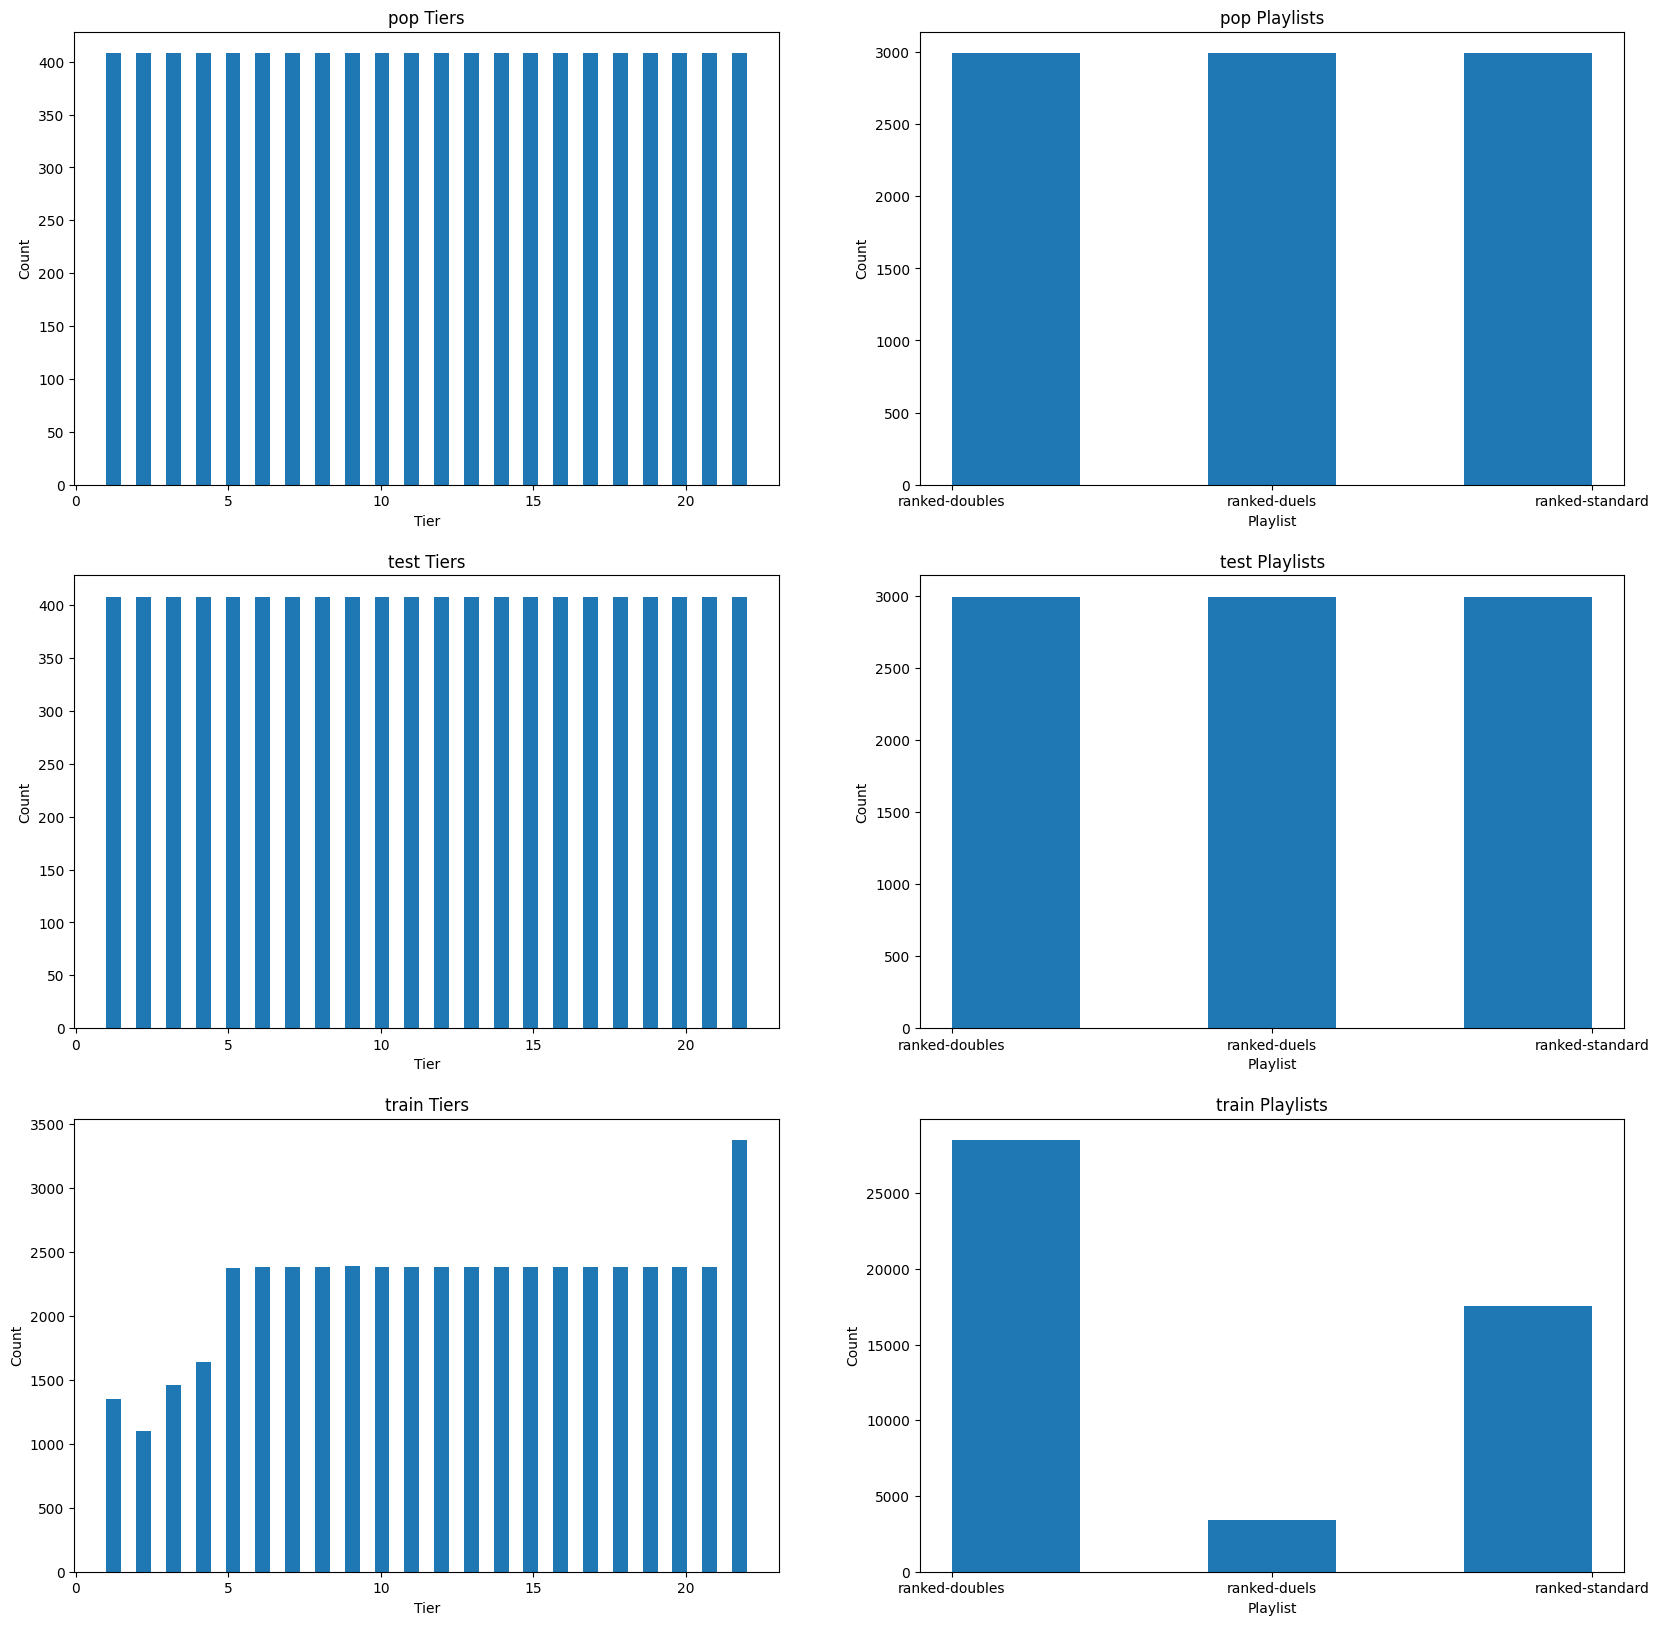

In [40]:
# plot the distribution of the dfs: playlists, and tiers^
dfs = {'pop': pop, 'test': test, 'train': df}
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
for i, key in enumerate(dfs):
    print(f'{key} shape: {dfs[key].shape}')

    ax[i][0].hist(dfs[key]['tier'], bins=len(tiers)+len(tiers)-1)
    ax[i][0].set_title(f'{key} Tiers')
    ax[i][0].set_xlabel('Tier')
    ax[i][0].set_ylabel('Count')

    ax[i][1].hist(dfs[key]['playlist_id'], bins=5)
    ax[i][1].set_title(f'{key} Playlists')
    ax[i][1].set_xlabel('Playlist')
    ax[i][1].set_ylabel('Count')

plt.show()